In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas import to_datetime
from collections import defaultdict
from scipy.stats.stats import pearsonr


In [ ]:
# Legge il CSV
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)
# Trasforma il campo "Sale" in un float
df["Sale"] = df["Sale"].str.replace(",", ".").astype(float)
# Trasforma il campo "BasketDate" in un datetime
df["BasketDate"] = pd.to_datetime(df["BasketDate"])

df.head()

# DATA SEMANTICS



In [ ]:
df.info()

Nel dataset si descrivono le sessioni di acquisto di un certo numero di clienti. Una sessione di acquisto, detta basket (`BasketID`) e si svolge in una data (`BasketDate`), e viene effettuata da un cliente (CustomerID) residente in uno stato (`CustomerCountry`).
Ogni sessione rappresenta una serie di prodotti acquistati da un cliente, e in un record è possibile ritrovare, per il singolo prodotto, l’identificativo (`ProdID`), la descrizione (`ProdDescr`), e  la quantità (`Qtà`). Infine viene riportato il costo unitario del prodotto (`Sale`).

# DISTRIBUTION OF VARIABLES AND STATISTICS


In [ ]:
df.describe()

In [ ]:
print("Distinct Values in BasketID: \n", df.BasketID.nunique())
print("Distinct Values in BasketDate:\n", df.BasketDate.nunique())
print("Distinct Values in Sale: \n", df.Sale.nunique())
print("Distinct Values in CustomerID: \n", df.CustomerID.nunique())
print("Distinct Values in CustomerCountry: \n", df.CustomerCountry.nunique())
print("Distinct Values in ProdID: \n", df.ProdID.nunique())
print("Distinct Values in ProdDescr: \n", df.ProdDescr.nunique())

## Date e ore di maggiore traffico nei negozi

## Orari di maggiore frequentazione

Di seguito si mostrano i diagrammi a barre contenenti il numero di `BasketID` per ora del giorno.

In [ ]:
df.groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

L'ora del giorno più frequentata sembra essere le 12.

Si restringono le date al 2010 e si osserva come in questo anno l'ora più frequentata siano le 14

In [ ]:
df[df["BasketDate"].dt.year == 2010].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

Mentre nel 2011 l'orario di maggiore frequenza si confermano le 12.

In [ ]:
df[df["BasketDate"].dt.year == 2011].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

## Date di maggiore frequentazione

Si mostrano le date di maggiore traffico per gli anni 2010 e 2011

Dato che relativamente al 2010 sono presenti solo 20 record è possibile mostrarli in un unico grafico

In [ ]:
df_2010 = df[df["BasketDate"].dt.year == 2010]

print(df_2010["BasketDate"].dt.date.nunique())

df_2010.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

TODO: Grafici per ogni gruppo di mesi del 2011

In [ ]:
first_three_months = df[(df["BasketDate"].dt.year == 2011) & (df["BasketDate"].dt.month < 3 )]

first_three_months.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

## Paesi in cui sono stati effettuati piu acquisti

In [ ]:
df.groupby('CustomerCountry')["BasketID"].nunique().plot(kind='bar',

title='Best buy coutry')

In [ ]:
#verificare a cosa è dovuta la variazione di prezzo
df.groupby(["ProdID",'Qta'])["Sale"].unique()

# ASSESSING DATA QUALITY (MISSING VALUES, OUTLIERS)

In [ ]:
df.info()

Si osserva che le uniche quantità settate a NaN sono `CustomerID` e le `ProdDescr`. I record che non hanno `CustomerID` non portano informazioni riguardo al profilo del cliente, mentre la `ProdDescr` può essere recuperata dai record con lo stesso `ProdID`.

In [ ]:
x = df[(df["ProdDescr"].fillna("").str.islower())]
display(x)
display("Number of BasketIDs", x["BasketID"].nunique())

Tutti i record che hanno `ProdDescr` scritta tutta in minuscolo hanno `CustomerID` a NaN e il loro carrello (`BasketID`) contiene un solo elemento. Si può quindi supporre che non si riferiscano ad una vera e propria transazione con un cliente, e si sceglie di eliminarli dal dataset.

In [ ]:
df = df[~(df["ProdDescr"].fillna("").str.islower())]

## Outliers nella quantità (`Qta`)

La distribuzione della quantità segue la seguente distribuzione:

In [ ]:
boxplot = df.boxplot(column=['Qta'])

Analizziamo meglio i record che si mostrano esterni al box plot:

In [ ]:
df[(df["Qta"] < -60000) | (df["Qta"] > 60000)]

Questi 4 record hanno le stesse caratteristiche e si eliminano a vicenda, per cui non portano informazione e possono essere eliminati.

In [ ]:
df = df[(df["Qta"] > -60000) & (df["Qta"] < 60000)]

In [ ]:
df[(df["Qta"] > -5000) & (df["Qta"] < 5000)].boxplot(column="Qta")

In [ ]:
df[(df["Qta"] < 0)]
#9752 record

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C"))]
#9084 di 9752 hanno BasketId che inizia con C, tutti con CustomerID 
#diverso da Nan ==> vengono mantenuti 

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C")) & (df['CustomerID'].isnull())]
#179 record con CustomerId=Nan ==> rimossi

In [ ]:
df[(df["Qta"] < 0) & (df["BasketID"].str.startswith("C")) & ~(df['CustomerID'].isnull())]
#infatti abbiamo 8905 record con CustomerID != Nan
#8905+179=9084

In [ ]:
df[df["Sale"] > 30000] #manual di valore massimo 
df[(df["ProdDescr"] == 'Manual')]
#se esiste un solo ProdId che ha tale Sale, possiamo fixarlo, altrimenti rimuoviamo/decidere
#potrebbe essere roba inserita a mano

Boxplot raggruppato per paese

In [ ]:
df.boxplot(column=["CustomerID"], by="CustomerCountry")

# Outliers in Sale

In [ ]:
df["Sale"].plot.box()

In [ ]:
df[(df["Sale"] < 0)]
#vengono rimossi

In [ ]:
df=df[(df["Sale"] >= 0)]

In [ ]:
df[df["Sale"] > 30000]
#viene mantenuto in quanto ha informazioni

# VARIABLES TRANSFORMATION & GENERATION

## Prezzo nullo

I record con prezzo 0 si considerano missing values, per cui si cerca di recuperare il valore di `Sale` a partire dalla media dei prezzi dello stesso `ProdID`.

In [ ]:
df["Sale"] = df.groupby("ProdID")["Sale"].transform(lambda group: group.replace(to_replace=0, method="ffill", value = group.mean()))

## ProdDescr non disponibile

Per rendere più interpretabili certe analisi riteniamo che sia utile recuperare la `ProdDescr` degli elementi che non l'hanno settata. Analogamente al caso precedente, si costruisce una funzione che recupera la descrizione di ogni prodotto dagli altri record.

In [ ]:
def replace_first_notna(group: pd.Series, column: str):
    # Indice del primo record con ProdID comune non NaN
    i: int = group.first_valid_index()
    # Se i è None non ci sono ProdDescr valide
    if i is None:
        return group
    # Valore di ProdDescr valido
    value = df.loc[i][column]
    return group.fillna(value)
 
df["ProdDescr"] = df.groupby("ProdID")["ProdDescr"].transform(lambda x: replace_first_notna(x, "ProdDescr"))

In [ ]:
df[df["ProdDescr"].isnull()]

# PAIRWISE CORRELATION & ELIMINATION OF REDUNTANT VARIABLES

Si discretizzano le variabili non numeriche all'interno del dataset:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy = df.copy()
for column in {"BasketID", "BasketDate", "CustomerCountry", "ProdID", "ProdDescr"}:
    df_copy[column] = le.fit_transform(df_copy[column].astype(str))

Si definisce la matrice di correlazione tra gli attributi:

In [ ]:
df_copy.corr().abs().style.background_gradient(cmap='coolwarm')

Dato che non si osservano correlazioni notevoli (maggiori dell'80%) non è il caso di eliminare attributi ridondanti.

In [ ]:
df.to_csv("./preprocessed.csv")

# DATA PREPARATION

Costruzione di attributi che caratterizzano il comportamento di un utente.

Si caricano i dati preprocessati, considerando per ora solo quelli con `CustomerID` non nullo:

In [3]:
df = pd.read_csv("./preprocessed.csv", index_col=0)
df = df[~(df["CustomerID"].isnull())]
df["BasketDate"] = pd.to_datetime(df["BasketDate"])
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,2011-09-12 12:50:00,2.10,12680.0,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,2011-09-12 12:50:00,4.15,12680.0,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,2011-09-12 12:50:00,4.15,12680.0,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,2011-09-12 12:50:00,4.95,12680.0,France,22138,BAKING SET 9 PIECE RETROSPOT,3


In [4]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

df["CustomerCountry"] = label.fit_transform(df["CustomerCountry"])

In [5]:
from indicators import customer_features

customer_indicators = df.groupby("CustomerID").apply(customer_features)
customer_indicators = pd.DataFrame(customer_indicators.values.tolist(), index=customer_indicators.index)
customer_indicators

,I,Iu,spending,Imax,returned_items,best_country,returning,max_cost,min_cost,most_bought_cost,most_returned_cost,avg_bought,avg_returned,hour,month,baskets,E
CustomerID,,,,,,,,,,,,,,,,,
12347.0,182,103,4310.00,676,0,16,0.00,12.75,NaN,3.75,0.00,2.644011,2.644011,14,7,7,6.015601
12348.0,31,22,1797.24,1254,0,12,0.00,40.00,NaN,0.29,0.00,5.764839,5.764839,19,12,4,4.233442
12349.0,73,73,1757.55,631,0,18,0.00,300.00,NaN,1.65,0.00,8.289041,8.289041,9,11,1,5.802215
12350.0,17,17,334.40,197,0,24,0.00,40.00,NaN,1.25,0.00,3.841176,3.841176,16,2,1,3.977269
12352.0,95,59,2506.04,127,66,24,-960.63,376.50,1.25,4.95,2.95,15.930706,15.930706,14,3,11,5.567352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,10,10,180.60,45,0,35,0.00,9.95,NaN,2.95,0.00,4.765000,4.765000,9,7,1,3.207542
18281.0,7,7,80.82,54,0,35,0.00,16.95,NaN,0.42,0.00,5.622857,5.622857,10,12,1,2.462523
18282.0,13,12,178.05,75,5,35,-1.45,12.75,0.29,12.75,0.29,5.199167,5.199167,13,5,3,2.660805


Per preparare adeguatamente il clustering si normalizzano i valori numerici e si assegnano label numeriche agli attributi non testuali.

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

labels = list(set(customer_indicators.columns) - {"best_country", "hour", "month"})

customer_indicators[labels] = scaler.fit_transform(customer_indicators[labels].fillna(0).values)
customer_indicators

,I,Iu,spending,Imax,returned_items,best_country,returning,max_cost,min_cost,most_bought_cost,most_returned_cost,avg_bought,avg_returned,hour,month,baskets,E
CustomerID,,,,,,,,,,,,,,,,,
12347.0,0.022676,0.056888,0.015336,0.060158,0.000000,16,1.000000,0.001566,0.000000,0.001844,0.000000,0.001300,0.001300,14,7,0.024291,0.628213
12348.0,0.003758,0.011712,0.006395,0.097953,0.000000,12,1.000000,0.004912,0.000000,0.000143,0.000000,0.002835,0.002835,19,12,0.012146,0.442101
12349.0,0.009020,0.040156,0.006254,0.057216,0.000000,18,1.000000,0.036843,0.000000,0.000812,0.000000,0.004077,0.004077,9,11,0.000000,0.605929
12350.0,0.002005,0.008924,0.001190,0.028837,0.000000,24,1.000000,0.004912,0.000000,0.000615,0.000000,0.001889,0.001889,16,2,0.000000,0.415349
12352.0,0.011776,0.032348,0.008917,0.024259,0.007051,24,0.975536,0.046237,0.000292,0.002435,0.000688,0.007836,0.007836,14,3,0.040486,0.581402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.001128,0.005020,0.000643,0.018898,0.000000,35,1.000000,0.001222,0.000000,0.001451,0.000000,0.002344,0.002344,9,7,0.000000,0.334966
18281.0,0.000752,0.003346,0.000288,0.019486,0.000000,35,1.000000,0.002082,0.000000,0.000207,0.000000,0.002766,0.002766,10,12,0.000000,0.257163
18282.0,0.001503,0.006135,0.000634,0.020859,0.000534,35,0.999963,0.001566,0.000068,0.006271,0.000068,0.002557,0.002557,13,5,0.008097,0.277870


## Hierarchical clustering

Si sperimentano varie invocazioni del metodo `linkage` e come i dendrogrammi generati cambiano al variare delle metriche adottate.

In [7]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [8]:
X = customer_indicators.values

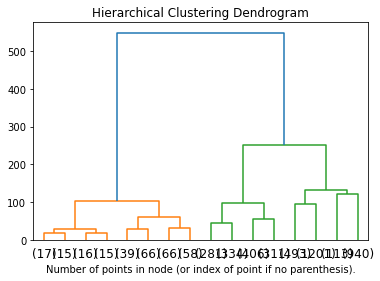

In [10]:
def hierarchical_clusterize(X, linkage):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage)
    model = model.fit(X)
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode='level', p=3)
    plt.xlabel(f"{linkage} linkage")
    plt.show()
